# Flanders

Flanders is a robust framework designed to protect federated learning systems from extreme model poisoning attacks. By leveraging multidimensional time series anomaly detection, it identifies malicious updates from participants, ensuring model integrity. Flanders enhances security in federated learning, promoting trustworthy collaboration across decentralized datasets without compromising privacy or performance.

#### Dependencies and Imports

In [ ]:
!pip install flwr==1.6.0 hydra-core==1.3.2 natsort==8.4.0 numpy==1.26.3 omegaconf==2.3.0 pandas==2.1.4 Pillow==10.2.0 ray==2.6.3 scikit_learn==1.3.2 scipy==1.12.0 torch==2.1.1 torchvision==0.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 673.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 570.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 16.0 MB/s eta 0:00:00
   ━

In [ ]:
import flwr as fl
import numpy as np
import tensorflow as tf
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr.common import FitIns
from flwr.common import parameters_to_ndarrays
from flwr.common import ndarrays_to_parameters
from flwr.common import EvaluateIns
from flwr.server.strategy import aggregate
import random
from numpy import ndarray

## Attacks

It defines a class *Attack* with a method drop_to_zero designed to modify an input list of trained_parameters. The method iterates over each parameter (assumed to be an array), setting all its elements to 0.1. During execution, it logs the operation with the client's ID (cid) for tracking or debugging purposes. A new list, new_params, is created to store the modified parameters, and this updated list is returned. The method ensures that the original structure of the trained_parameters is preserved while uniformly altering their values. This may simulate an "attack" by degrading trained model parameters.



In [ ]:
class Attack:
    def drop_to_zero(self, trained_parameters, cid) -> ndarray:
            log(INFO, "Applying Drop Parameters Attack Client %s", cid)
            new_params = []
            for p in trained_parameters:
                p[:] = 0.1
                new_params.append(p)
            return new_params


#### Helpers

In [ ]:
def flatten_params(params):
    """Transform a list of (layers-)parameters into a single vector of shape (n)."""
    return np.concatenate(params, axis=None).ravel()


def save_params(
        parameters, cid, params_dir="clients_params", remove_last=False, rrl=False
):
    """Save parameters in a file.

    Args:
    - parameters (ndarray): decoded parameters to append at the end of the file
    - cid (int): identifier of the client
    - remove_last (bool):
        if True, remove the last saved parameters and replace with "parameters"
    - rrl (bool):
        if True, remove the last saved parameters and replace with the ones
        saved before this round.
    """
    new_params = parameters
    # Save parameters in clients_params/cid_params
    path_file = f"{params_dir}/{cid}_params.npy"
    if os.path.exists(params_dir) is False:
        os.mkdir(params_dir)
    if os.path.exists(path_file):
        # load old parameters
        old_params = np.load(path_file, allow_pickle=True)
        if remove_last:
            old_params = old_params[:-1]
            if rrl:
                new_params = old_params[-1]

        # add new parameters
        new_params = np.vstack((old_params, new_params))

    # save parameters
    np.save(path_file, new_params)


def load_all_time_series(params_dir="clients_params", window=0):
    """Load all time series.

    Load all time series in order to have a tensor of shape (m,T,n)
    where:
    - T := time;
    - m := number of clients;
    - n := number of parameters.
    """
    files = os.listdir(params_dir)
    files = natsorted(files)
    data = []
    for file in files:
        data.append(np.load(os.path.join(params_dir, file), allow_pickle=True))
    return np.array(data, dtype="float64")[:, -window:, :]


def l2_norm(true_matrix, predicted_matrix):
    """Compute the l2 norm between two matrices.

    Parameters
    ----------
    true_matrix : ndarray
        The true matrix.
    predicted_matrix : ndarray
        The predicted matrix by MAR.

    Returns
    -------
    anomaly_scores : ndarray
        1-d array of anomaly scores.
    """
    delta = np.subtract(true_matrix, predicted_matrix)
    anomaly_scores = np.sum(delta ** 2, axis=-1) ** (1.0 / 2)
    return anomaly_scores


def mar(X, pred_step, alpha=1, beta=1, maxiter=100, start=0):
    """Forecast the next tensor of params.

    Forecast the next tensor of params by using MAR algorithm.
    """
    m, n, T = X.shape
    start = 0

    A = np.random.randn(m, m)
    B = np.random.randn(n, n)
    X_norm = (X - np.min(X)) / np.max(X)

    for _ in range(maxiter):
        temp0 = B.T @ B
        temp1 = np.zeros((m, m))
        temp2 = np.zeros((m, m))
        identity_m = np.identity(m)

        for t in range(start, T):
            temp1 += X_norm[:, :, t] @ B @ X_norm[:, :, t - 1].T
            temp2 += X_norm[:, :, t - 1] @ temp0 @ X_norm[:, :, t - 1].T

        temp2 += alpha * identity_m
        A = temp1 @ np.linalg.inv(temp2)

        temp0 = A.T @ A
        temp1 = np.zeros((n, n))
        temp2 = np.zeros((n, n))
        identity_n = np.identity(n)

        for t in range(start, T):
            temp1 += X_norm[:, :, t].T @ A @ X_norm[:, :, t - 1]
            temp2 += X_norm[:, :, t - 1].T @ temp0 @ X_norm[:, :, t - 1]

        temp2 += beta * identity_n
        B = temp1 @ np.linalg.inv(temp2)

    tensor = np.append(X, np.zeros((m, n, pred_step)), axis=2)
    for s in range(pred_step):
        tensor[:, :, T + s] = A @ tensor[:, :, T + s - 1] @ B.T
    return tensor[:, :, -pred_step:]


### Client

The Client class extends fl.client.NumPyClient to simulate a federated learning client. It initializes with a client ID (cid), data distribution type (niid), the total number of clients, and Dirichlet distribution parameter (dirichlet_alpha). Data is partitioned using either IID or Dirichlet methods and loaded from an MNIST dataset. A simple neural network is created as the model. In the fit method, the client trains the model for one epoch and logs performance metrics. If the client meets certain criteria, it applies an attack (e.g., set all weights to 0.1) to the trained parameters. The evaluate method evaluates the model on test data.








In [ ]:
class Client(fl.client.NumPyClient):
    def __init__(self, cid, niid, num_clients, dirichlet_alpha):
        self.cid = int(cid)
        self.niid = niid
        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha

        self.x_train, self.y_train, self.x_test, self.y_test = self.load_data()
        self.model = self.create_model(self.x_train.shape)
        self.attack = Attack()

    def get_parameters(self, config):
        return self.model.get_weights()

    def load_data(self):
        if self.niid:
            partitioner_train = DirichletPartitioner(num_partitions=self.num_clients, partition_by="label",
                                                     alpha=self.dirichlet_alpha, min_partition_size=0,
                                                     self_balancing=False)
            partitioner_test = DirichletPartitioner(num_partitions=self.num_clients, partition_by="label",
                                                    alpha=self.dirichlet_alpha, min_partition_size=0,
                                                    self_balancing=False)
        else:
            partitioner_train = IidPartitioner(num_partitions=self.num_clients)
            partitioner_test = IidPartitioner(num_partitions=self.num_clients)

        fds = FederatedDataset(dataset='mnist', partitioners={"train": partitioner_train})
        train = fds.load_partition(self.cid).with_format("numpy")

        fds_eval = FederatedDataset(dataset='mnist', partitioners={"test": partitioner_test})
        test = fds_eval.load_partition(self.cid).with_format("numpy")

        return train['image'] / 255.0, train['label'], test['image'] / 255.0, test['label']

    def create_model(self, input_shape):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),

        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

    def __was_chosen(self):
        return self.cid % 2 == 0

    def fit(self, parameters, config):
        self.model.set_weights(parameters)

        history = self.model.fit(self.x_train, self.y_train, epochs=1)
        acc = np.mean(history.history['accuracy'])
        loss = np.mean(history.history['loss'])

        trained_parameters = self.model.get_weights()

        if self.__was_chosen():
            trained_parameters = self.attack.gaussian_attack(trained_parameters, self.cid)

        fit_msg = {
            'cid': self.cid,
            'accuracy': acc,
            'loss': loss,
        }

        self.log_client('train.csv', config['server_round'], acc, loss)
        return trained_parameters, len(self.x_train), fit_msg

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)

        loss, acc = self.model.evaluate(self.x_test, self.y_test)
        eval_msg = {
            'cid': self.cid,
            'accuracy': acc,
            'loss': loss
        }
        self.log_client('evaluate.csv', config['server_round'], acc, loss)
        return loss, len(self.x_test), eval_msg

    def log_client(self, file_name, server_round, acc, loss):
        with open(file_name, 'a') as file:
            file.write(f'{server_round}, {self.cid}, {acc}, {loss}\n')

## Server

The aggregate_fit function processes client training results during a federated learning round. It saves each client's parameters, optionally sampling a subset for efficiency. If past rounds exist, it loads time-series parameters, uses MAR (Matrix AutoRegressive model) to predict values, and calculates anomaly scores with L2 norm. Clients with the lowest anomaly scores are considered "good" and selected for aggregation. It logs client information and aggregates selected client weights, converting them back to a global model format. This ensures robust aggregation by focusing on consistent clients, enhancing the server's model quality while potentially mitigating the impact of anomalies or attacks.

#### aggregate_fit

In [ ]:
    def aggregate_fit(
            self,
            server_round: int,
            results: List[Tuple[ClientProxy, FitRes]],
            failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        #Save parameters of each client as time series
        ordered_results = [0 for _ in range(len(results))]
        for proxy, fit_res in results:
            params = flatten_params(parameters_to_ndarrays(fit_res.parameters))
            if self.sampling > 0:
                # if the sampling number is greater than the number of
                # parameters, just sample all of them
                self.sampling = min(self.sampling, len(params))
                if len(self.params_indexes) == 0:
                    # Sample a random subset of parameters
                    self.params_indexes = np.random.randint(
                        0, len(params), size=self.sampling
                    )

                params = params[self.params_indexes]
            cid = fit_res.metrics["cid"]
            log(INFO, "Saving parameters for client %s", cid)
            save_params(params, fit_res.metrics["cid"])

        if server_round > 1:
            params_tensor = load_all_time_series(
                params_dir="clients_params", window=0
            )
            params_tensor = np.transpose(
                params_tensor, (0, 2, 1)
            )  # (clients, params, time)
            ground_truth = params_tensor[:, :, -1].copy()
            pred_step = 1
            predicted_matrix = mar(
                params_tensor[:, :, :-1],
                pred_step,
                maxiter=100, # number of iterations done by MAR
                alpha=1,
                beta=1,
            )

            anomaly_scores = l2_norm(
                ground_truth, predicted_matrix[:, :, 0]
            )
            good_clients_idx = sorted(
                np.argsort(anomaly_scores)[: 3]
            )  # noqa
            log(INFO, "Size of results  %s", len(results))
            results = np.array(results)[good_clients_idx].tolist()
            log(INFO, "Good clients: %s", good_clients_idx)

        log(INFO, "Applying aggregate_fn")
        # Convert results
        log(INFO, "Size of results after Flanders %s", len(results))

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(
            aggregate(weights_results)
        )

        return parameters_aggregated, {}

## Simulation

In [ ]:
def create_client(cid):
    print(f"Client id == {cid}")
    client = Client(cid, True, 5, 0.1)
    return client.to_client()


class Simulation:
    def __init__(self):
        self.server = Server(num_clients=10, dirichlet_alpha=0.1, fraction_fit=0.2)

    def run_simulation(self):
        fl.simulation.start_simulation(
            client_fn=create_client,
            num_clients=10,
            config=fl.server.ServerConfig(num_rounds=10),
            strategy=self.server)


if __name__ == "__main__":
    Simulation().run_simulation()

## Data Visualization

#### No Attack

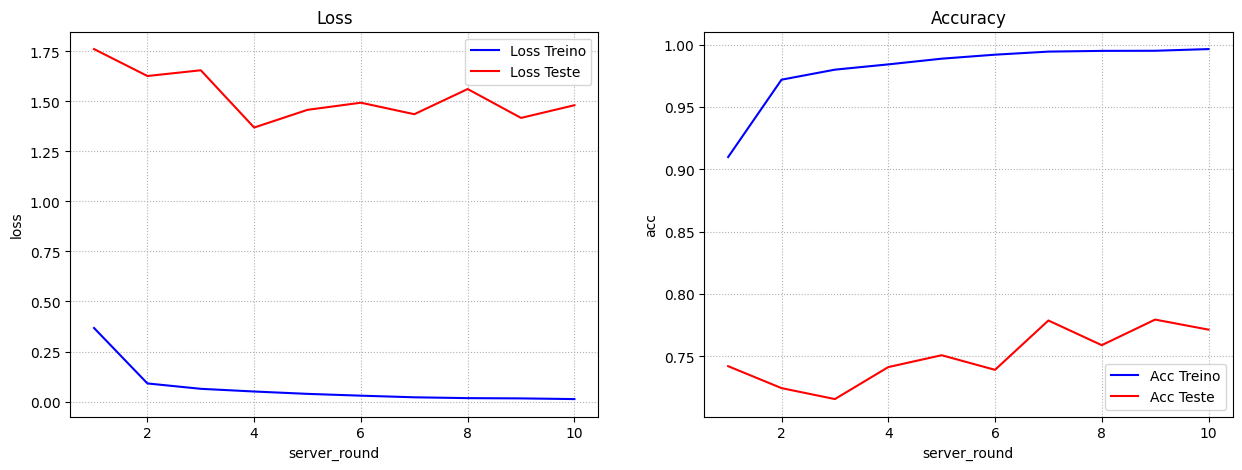

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('na-train.csv', names=['server_round', 'cid', 'acc', 'loss'])
df_test  = pd.read_csv('na-evaluate.csv', names=['server_round', 'cid', 'acc', 'loss'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


sns.lineplot(data=df_train, x='server_round', y='loss', ax=ax[0], color='b', label='Loss Treino')
sns.lineplot(data=df_train, x='server_round', y='acc', ax=ax[1], color='b', label='Acc Treino')
sns.lineplot(data=df_test, x='server_round', y='loss', ax=ax[0], color='r', label='Loss Teste')
sns.lineplot(data=df_test, x='server_round', y='acc', ax=ax[1], color='r', label='Acc Teste')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

ax[0].grid(True, linestyle=':')
ax[1].grid(True, linestyle=':')

#### No Flanders

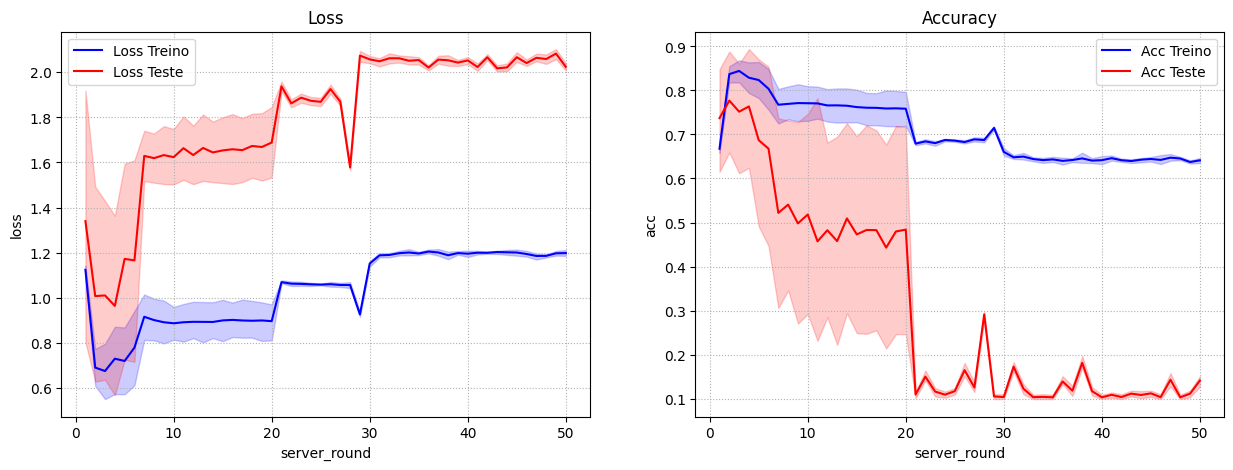

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('nf-train.csv', names=['server_round', 'cid', 'acc', 'loss'])
df_test  = pd.read_csv('nf-evaluate.csv', names=['server_round', 'cid', 'acc', 'loss'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


sns.lineplot(data=df_train, x='server_round', y='loss', ax=ax[0], color='b', label='Loss Treino')
sns.lineplot(data=df_train, x='server_round', y='acc', ax=ax[1], color='b', label='Acc Treino')
sns.lineplot(data=df_test, x='server_round', y='loss', ax=ax[0], color='r', label='Loss Teste')
sns.lineplot(data=df_test, x='server_round', y='acc', ax=ax[1], color='r', label='Acc Teste')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

ax[0].grid(True, linestyle=':')
ax[1].grid(True, linestyle=':')

#### Flanders Filter

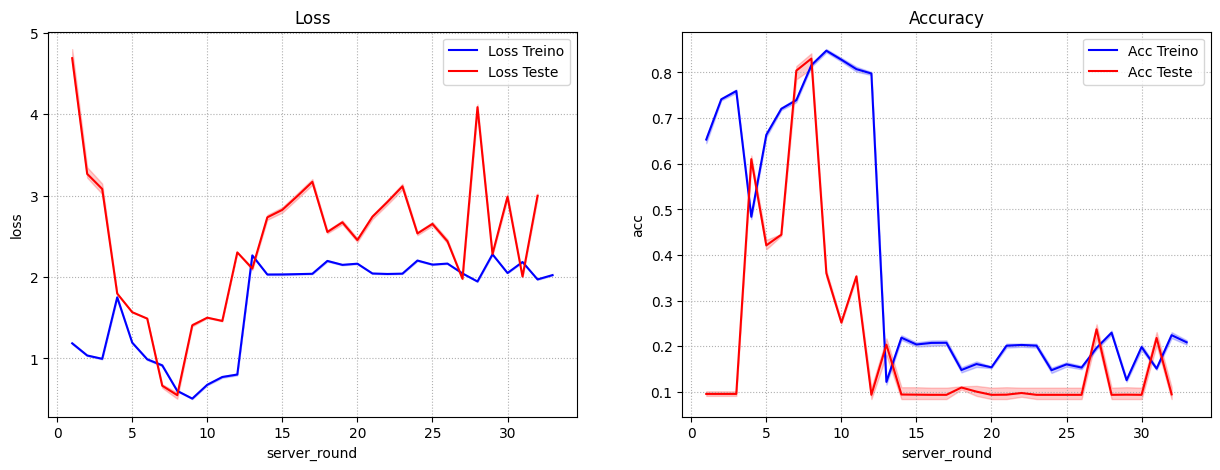

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('f-train.csv', names=['server_round', 'cid', 'acc', 'loss'])
df_test  = pd.read_csv('f-evaluate.csv', names=['server_round', 'cid', 'acc', 'loss'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


sns.lineplot(data=df_train, x='server_round', y='loss', ax=ax[0], color='b', label='Loss Treino')
sns.lineplot(data=df_train, x='server_round', y='acc', ax=ax[1], color='b', label='Acc Treino')
sns.lineplot(data=df_test, x='server_round', y='loss', ax=ax[0], color='r', label='Loss Teste')
sns.lineplot(data=df_test, x='server_round', y='acc', ax=ax[1], color='r', label='Acc Teste')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

ax[0].grid(True, linestyle=':')
ax[1].grid(True, linestyle=':')

## Full Code

In [ ]:
import os
import random
from logging import INFO, ERROR
from typing import Dict, List, Optional, Tuple, Union

import flwr as fl
import numpy as np
import tensorflow as tf
from flwr.common import EvaluateIns
from flwr.common import (
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import aggregate
from flwr.server.strategy.aggregate import aggregate
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from natsort import natsorted
from numpy import ndarray


def flatten_params(params):
    """Transform a list of (layers-)parameters into a single vector of shape (n)."""
    return np.concatenate(params, axis=None).ravel()


def save_params(
        parameters, cid, params_dir="clients_params", remove_last=False, rrl=False
):
    """Save parameters in a file.

    Args:
    - parameters (ndarray): decoded parameters to append at the end of the file
    - cid (int): identifier of the client
    - remove_last (bool):
        if True, remove the last saved parameters and replace with "parameters"
    - rrl (bool):
        if True, remove the last saved parameters and replace with the ones
        saved before this round.
    """
    new_params = parameters
    # Save parameters in clients_params/cid_params
    path_file = f"{params_dir}/{cid}_params.npy"
    if os.path.exists(params_dir) is False:
        os.mkdir(params_dir)
    if os.path.exists(path_file):
        # load old parameters
        old_params = np.load(path_file, allow_pickle=True)
        if remove_last:
            old_params = old_params[:-1]
            if rrl:
                new_params = old_params[-1]

        # add new parameters
        new_params = np.vstack((old_params, new_params))

    # save parameters
    np.save(path_file, new_params)


def load_all_time_series(params_dir="clients_params", window=0):
    """Load all time series.

    Load all time series in order to have a tensor of shape (m,T,n)
    where:
    - T := time;
    - m := number of clients;
    - n := number of parameters.
    """
    files = os.listdir(params_dir)
    files = natsorted(files)
    data = []
    for file in files:
        data.append(np.load(os.path.join(params_dir, file), allow_pickle=True))
    return np.array(data, dtype="float64")[:, -window:, :]


def l2_norm(true_matrix, predicted_matrix):
    """Compute the l2 norm between two matrices.

    Parameters
    ----------
    true_matrix : ndarray
        The true matrix.
    predicted_matrix : ndarray
        The predicted matrix by MAR.

    Returns
    -------
    anomaly_scores : ndarray
        1-d array of anomaly scores.
    """
    delta = np.subtract(true_matrix, predicted_matrix)
    anomaly_scores = np.sum(delta ** 2, axis=-1) ** (1.0 / 2)
    return anomaly_scores


def mar(X, pred_step, alpha=1, beta=1, maxiter=100, start=0):
    """Forecast the next tensor of params.

    Forecast the next tensor of params by using MAR algorithm.
    """
    m, n, T = X.shape
    start = 0

    A = np.random.randn(m, m)
    B = np.random.randn(n, n)
    X_norm = (X - np.min(X)) / np.max(X)

    for _ in range(maxiter):
        temp0 = B.T @ B
        temp1 = np.zeros((m, m))
        temp2 = np.zeros((m, m))
        identity_m = np.identity(m)

        for t in range(start, T):
            temp1 += X_norm[:, :, t] @ B @ X_norm[:, :, t - 1].T
            temp2 += X_norm[:, :, t - 1] @ temp0 @ X_norm[:, :, t - 1].T

        temp2 += alpha * identity_m
        A = temp1 @ np.linalg.inv(temp2)

        temp0 = A.T @ A
        temp1 = np.zeros((n, n))
        temp2 = np.zeros((n, n))
        identity_n = np.identity(n)

        for t in range(start, T):
            temp1 += X_norm[:, :, t].T @ A @ X_norm[:, :, t - 1]
            temp2 += X_norm[:, :, t - 1].T @ temp0 @ X_norm[:, :, t - 1]

        temp2 += beta * identity_n
        B = temp1 @ np.linalg.inv(temp2)

    tensor = np.append(X, np.zeros((m, n, pred_step)), axis=2)
    for s in range(pred_step):
        tensor[:, :, T + s] = A @ tensor[:, :, T + s - 1] @ B.T
    return tensor[:, :, -pred_step:]


class Attack:

    def __init__(self):
        self.magnitude = 0.05

    def __pertubate(self, vect: ndarray) -> ndarray:
        return np.random.normal(loc=0, scale=self.magnitude, size=vect.size)

    def gaussian_attack(self, trained_parameters, cid) -> ndarray:
        new_params = []

        for p in trained_parameters:
            if p.size == 1:
                # Perturb scalar values (single element arrays)
                perturbed = self.__pertubate(p)
                new_params.append(np.array([perturbed]))  # Return as a 2D array with shape (1, size)
            else:
                # Perturb multi-dimensional arrays (like weight matrices)
                perturbed = np.apply_along_axis(self.__pertubate, 0, p)
                new_params.append(perturbed)  # Append directly as a 2D array
        log(INFO, "Applying Gaussian Noise for Client %s", cid)
        return new_params

    def drop_to_zero(self, trained_parameters, cid) -> ndarray:
        log(INFO, "Applying Drop Parameters Attack Client %s", cid)
        new_params = []
        for p in trained_parameters:
            p[:] = 0.1
            new_params.append(p)
        return new_params


class Client(fl.client.NumPyClient):
    def __init__(self, cid, niid, num_clients, dirichlet_alpha):
        self.cid = int(cid)
        self.niid = niid
        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha

        self.x_train, self.y_train, self.x_test, self.y_test = self.load_data()
        self.model = self.create_model(self.x_train.shape)
        self.attack = Attack()

    def get_parameters(self, config):
        return self.model.get_weights()

    def load_data(self):
        if self.niid:
            partitioner_train = DirichletPartitioner(num_partitions=self.num_clients, partition_by="label",
                                                     alpha=self.dirichlet_alpha, min_partition_size=0,
                                                     self_balancing=False)
            partitioner_test = DirichletPartitioner(num_partitions=self.num_clients, partition_by="label",
                                                    alpha=self.dirichlet_alpha, min_partition_size=0,
                                                    self_balancing=False)
        else:
            partitioner_train = IidPartitioner(num_partitions=self.num_clients)
            partitioner_test = IidPartitioner(num_partitions=self.num_clients)

        fds = FederatedDataset(dataset='mnist', partitioners={"train": partitioner_train})
        train = fds.load_partition(self.cid).with_format("numpy")

        fds_eval = FederatedDataset(dataset='mnist', partitioners={"test": partitioner_test})
        test = fds_eval.load_partition(self.cid).with_format("numpy")

        return train['image'] / 255.0, train['label'], test['image'] / 255.0, test['label']

    def create_model(self, input_shape):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),

        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

    def __was_chosen(self):
        return self.cid % 2 == 0

    def fit(self, parameters, config):
        self.model.set_weights(parameters)

        history = self.model.fit(self.x_train, self.y_train, epochs=1)
        acc = np.mean(history.history['accuracy'])
        loss = np.mean(history.history['loss'])

        trained_parameters = self.model.get_weights()

        if self.__was_chosen():
            trained_parameters = self.attack.drop_to_zero(trained_parameters, self.cid)

        fit_msg = {
            'cid': self.cid,
            'accuracy': acc,
            'loss': loss,
        }

        self.log_client('f-train.csv', config['server_round'], acc, loss)
        return trained_parameters, len(self.x_train), fit_msg

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)

        loss, acc = self.model.evaluate(self.x_test, self.y_test)
        eval_msg = {
            'cid': self.cid,
            'accuracy': acc,
            'loss': loss
        }
        self.log_client('f-evaluate.csv', config['server_round'], acc, loss)
        return loss, len(self.x_test), eval_msg

    def log_client(self, file_name, server_round, acc, loss):
        with open(file_name, 'a') as file:
            file.write(f'{server_round}, {self.cid}, {acc}, {loss}\n')


class Server(fl.server.strategy.FedAvg):
    def __init__(self, num_clients, dirichlet_alpha, fraction_fit=0.7, fraction_eval=0.3):
        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha
        self.sampling = 10
        self.params_indexes: List = []

        self.clients_data = {
            "training_clients": [],
            "validation_clients": []
        }

        super().__init__(fraction_fit=fraction_fit, fraction_evaluate=fraction_eval, min_available_clients=num_clients)

    def configure_fit(self, server_round, parameters, client_manager):
        """Configure the next round of training."""

        config = {
            'server_round': server_round,
        }
        fit_ins = FitIns(parameters, config)

        if len(self.clients_data["training_clients"]) < 1:
            clients = client_manager.sample(
                num_clients=10
            )
            training_percentage = int(len(clients) * 0.7)

            self.clients_data["training_clients"] = random.sample(clients, training_percentage)
            self.clients_data["validation_clients"] = list(set(clients) - set(self.clients_data["training_clients"]))

        return [(client, fit_ins) for client in self.clients_data["training_clients"]]

    def aggregate_fit(
            self,
            server_round: int,
            results: List[Tuple[ClientProxy, FitRes]],
            failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        #Save parameters of each client as time series
        ordered_results = [0 for _ in range(len(results))]
        for proxy, fit_res in results:
            params = flatten_params(parameters_to_ndarrays(fit_res.parameters))
            if self.sampling > 0:
                # if the sampling number is greater than the number of
                # parameters, just sample all of them
                self.sampling = min(self.sampling, len(params))
                if len(self.params_indexes) == 0:
                    # Sample a random subset of parameters
                    self.params_indexes = np.random.randint(
                        0, len(params), size=self.sampling
                    )

                params = params[self.params_indexes]
            cid = fit_res.metrics["cid"]
            log(INFO, "Saving parameters for client %s", cid)
            save_params(params, fit_res.metrics["cid"])

        if server_round > 1:
            params_tensor = load_all_time_series(
                params_dir="clients_params", window=0
            )
            params_tensor = np.transpose(
                params_tensor, (0, 2, 1)
            )  # (clients, params, time)
            ground_truth = params_tensor[:, :, -1].copy()
            pred_step = 1
            predicted_matrix = mar(
                params_tensor[:, :, :-1],
                pred_step,
                maxiter=100, # number of iterations done by MAR
                alpha=1,
                beta=1,
            )

            anomaly_scores = l2_norm(
                ground_truth, predicted_matrix[:, :, 0]
            )
            good_clients_idx = sorted(
                np.argsort(anomaly_scores)[: 3]
            )  # noqa
            log(INFO, "Size of results  %s", len(results))
            results = np.array(results)[good_clients_idx].tolist()
            log(INFO, "Good clients: %s", good_clients_idx)

        log(INFO, "Applying aggregate_fn")
        # Convert results
        log(INFO, "Size of results after Flanders %s", len(results))

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(
            aggregate(weights_results)
        )

        return parameters_aggregated, {}

    def configure_evaluate(self, server_round, parameters, client_manager):
        config = {
            'server_round': server_round,
        }

        evaluate_ins = EvaluateIns(parameters, config)
        return [(client, evaluate_ins) for client in self.clients_data["validation_clients"]]

    def aggregate_evaluate(self, server_round, results, failures):
        accuracies = []

        for _, response in results:
            acc = response.metrics['accuracy']
            accuracies.append(acc)

        avg_acc = sum(accuracies) / len(accuracies)
        log(INFO, "Round %s aggregate accuracy: %s", server_round, avg_acc)

        return avg_acc, {}


def create_client(cid):
    log(INFO, "Creating client with id = %s", cid)
    client = Client(cid, False, 10, 0.1)
    return client.to_client()


class Simulation:
    def __init__(self):
        self.server = Server(num_clients=10, dirichlet_alpha=0.1, fraction_fit=0.7, fraction_eval=0.3)

    def run_simulation(self):
        fl.simulation.start_simulation(
            client_fn=create_client,
            num_clients=10,
            config=fl.server.ServerConfig(num_rounds=50),
            strategy=self.server)


if __name__ == "__main__":
    Simulation().run_simulation()
